In [1]:
import os
import urllib.request
import zipfile
import glob
import random
import numpy as np
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

In [2]:
%matplotlib inline
torch.manual_seed(1106)
np.random.seed(1106)
random.seed(1106)

In [3]:
print('PyTorch version: ', torch.__version__)
print('torchvision version: ', torchvision.__version__)

PyTorch version:  1.11.0a0+bfe5ad2
torchvision version:  0.12.0a0


In [4]:
net = models.vgg16(pretrained=True)
net.eval()
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
class BaseTransform():
    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.base_transform(img)

In [6]:
url = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
path = '/home/dotdash/data/imagenet_class_index.json'
if not os.path.exists(path):
    urllib.request.urlretrieve(url, path)

In [7]:
class ILSVRCPredictor():
    def __init__(self, class_index):
        self.class_index = class_index
        
    def predict_max(self, out):
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]
        
        return predicted_label_name

In [8]:
ILSVRC_class_index = json.load(open(path, 'r'))
predictor = ILSVRCPredictor(ILSVRC_class_index)
img = Image.open('/home/dotdash/data/goldenretriever-3724972_640.jpg')
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)
inputs = img_transformed.unsqueeze_(0)
out = net(inputs)
result = predictor.predict_max(out)
print('predicted result of input image: ', result)

predicted result of input image:  golden_retriever


In [9]:
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
path = '/home/dotdash/data/hymenoptera_data.zip'

if not os.path.exists(path):
    urllib.request.urlretrieve(url, path)
    zip = zipfile.ZipFile(path)
    zip.extractall('/home/dotdash/data')
    zip.close()
    os.remove(path)

In [10]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase=None):
        if phase is None:
            phase = 'train'
        else:
            pass
        
        return self.data_transform[phase](img)

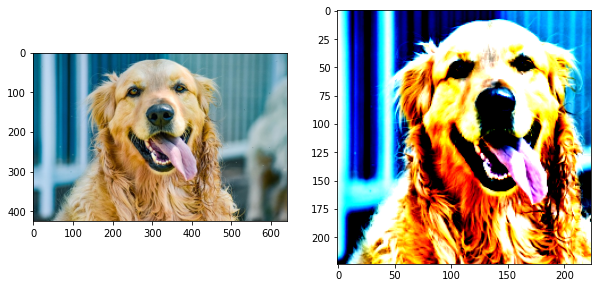

In [11]:
img = Image.open('/home/dotdash/data/goldenretriever-3724972_640.jpg')
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train')
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);plt.imshow(np.array(img));
plt.subplot(1,2,2);plt.imshow(np.clip(img_transformed.numpy().transpose(1,2,0),0,1));

In [12]:
def make_datapath_list(phase):
    return [i for i in glob.glob(f"/home/dotdash/ch01/data/hymenoptera_data/{phase}/*/*.jpg")]

In [14]:
class HymenopteraDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase=None):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split('/')[-2]
        if label == 'ants':
            label = 0
        elif label == 'bees':
            label = 1
            
        return img_transformed, label

In [15]:
train_dataset = HymenopteraDataset(
    file_list=make_datapath_list('train'),
    transform=ImageTransform(size, mean, std),
    phase='train'
)

val_dataset = HymenopteraDataset(
    file_list=make_datapath_list('val'),
    transform=ImageTransform(size, mean, std),
    phase='val'
)

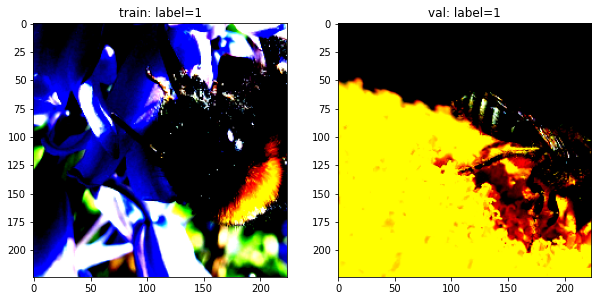

In [32]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.title(f"train: label={train_dataset.__getitem__(0)[1]}");
plt.imshow(np.clip(train_dataset.__getitem__(0)[0].numpy().transpose(1,2,0),0,1));
plt.subplot(1,2,2);
plt.title(f"val: label={train_dataset.__getitem__(0)[1]}");
plt.imshow(np.clip(val_dataset.__getitem__(0)[0].numpy().transpose(1,2,0),0,1));

In [35]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    for epoch in range(num_epochs):
        print(f"epoch {epoch+1}/{num_epochs}")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            if (epoch == 0) and (phase == 'train'):
                continue

            for inputs, labels in tqdm(dataloaders_dict[phase]):    
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print(f"{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}")

In [36]:
batch_size = 32

train_dataloader = data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloaders_dict = {
    'train': train_dataloader,
    'val': val_dataloader,
}

batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)

net = models.vgg16(pretrained=True)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
criterion = nn.CrossEntropyLoss()
params_to_update = []
update_param_names = ['classifier.6.weight', 'classifier.6.bias']

for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False

optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

epoch 1/2


100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.20s/it]


val loss: 0.6041, acc: 0.6340
epoch 2/2


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.31s/it]


train loss: 0.4486, acc: 0.7860


100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.38s/it]

val loss: 0.1800, acc: 0.9477
